# Imports, Data Partitioning, Server and Client Class

In [6]:
###
# STEP 1: IMPORTS, PARAMETERS, AND MODEL
###

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import random
import copy

# --- 1.1: Reproducibility ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"Set random seed to {SEED}.")

# --- 1.2: Task 1 Parameters ---
# As per the manual, we use a "tiny learning rate" for this
# full-batch gradient descent.
LEARNING_RATE = 0.05
ITERATIONS = 20 # "say 10 to 20 iterations"
NUM_CLIENTS = 5
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Device: {DEVICE}")
print(f"Config: {NUM_CLIENTS} clients, {LEARNING_RATE} LR, {ITERATIONS} iterations.")

# --- 1.3: Model Architecture ---
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# --- 1.4: Save Initial Model State ---
global_model = SimpleCNN().to(DEVICE)
INITIAL_MODEL_STATE = copy.deepcopy(global_model.state_dict())
print("SimpleCNN model defined and initial state saved.")

Set random seed to 42.
Device: cuda
Config: 5 clients, 0.05 LR, 20 iterations.
SimpleCNN model defined and initial state saved.


In [7]:
###
# STEP 2: DATA LOADING AND PARTITIONING
###

# --- 2.1: Load Dataset ---
transform_cifar = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_cifar
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_cifar
)

# Test loader will be used for evaluation
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
print(f"Loaded CIFAR-10: {len(train_dataset)} train, {len(test_dataset)} test samples.")

# --- 2.2: Partitioning Function ---
def create_iid_partitions(dataset, num_clients):
    num_samples = len(dataset)
    indices = list(range(num_samples))
    samples_per_client = num_samples // num_clients
    np.random.shuffle(indices)
    
    list_of_datasets = []
    for i in range(num_clients):
        start_idx = i * samples_per_client
        end_idx = (i + 1) * samples_per_client if i != num_clients - 1 else num_samples
        client_indices = indices[start_idx:end_idx]
        list_of_datasets.append(Subset(dataset, client_indices))
    return list_of_datasets

# --- 2.3: Create Partitions ---
client_datasets = create_iid_partitions(train_dataset, NUM_CLIENTS)
for i, ds in enumerate(client_datasets):
    print(f"  Client {i}: {len(ds)} samples")

Loaded CIFAR-10: 50000 train, 10000 test samples.
  Client 0: 10000 samples
  Client 1: 10000 samples
  Client 2: 10000 samples
  Client 3: 10000 samples
  Client 4: 10000 samples


In [8]:
###
# STEP 3: CENTRALIZED SGD TRAINER (FULL-BATCH)
###

# This function matches the manual:
# "compute the gradient on the entire batch of combined data"
# "run... 5 centralized SGD steps"

def train_centralized(initial_state, criterion, device):
    print("\n--- Starting Centralized SGD Training ---")
    
    model = SimpleCNN().to(device)
    model.load_state_dict(copy.deepcopy(initial_state))
    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
    
    # Create a FULL-BATCH data loader
    train_loader = DataLoader(train_dataset, batch_size=len(train_dataset))
    
    history = {'loss': [], 'accuracy': []}
    
    # Get the one and only batch (the entire dataset)
    # This simulates the setup, though in a loop we'd just re-use it
    full_data_batch = next(iter(train_loader))
    
    for i in range(ITERATIONS):
        data, labels = full_data_batch[0].to(device), full_data_batch[1].to(device)
        
        # --- Perform one full-batch gradient step ---
        model.train()
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # --- End of step ---
        
        # --- Evaluate ---
        acc, loss_val = evaluate(model, test_loader, criterion, device)
        history['loss'].append(loss_val)
        history['accuracy'].append(acc)
        
        print(f"Iteration {i+1}/{ITERATIONS}: Test Loss = {loss_val:.4f}, Test Acc = {acc:.2f}%")
        
    print("--- Centralized Training Finished ---")
    return history, model.state_dict()

# --- Helper function for evaluation ---
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, labels in test_loader:
            data, labels = data.to(device), labels.to(device)
            outputs = model(data)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    avg_loss = test_loss / total
    accuracy = 100 * correct / total
    return accuracy, avg_loss

In [9]:
###
# STEP 4: FedSGD TRAINER (FULL-LOCAL-BATCH)
###

# This function matches the manual:
# "Each client computes the gradient on its whole local set"
# "...using a single batch that is the entire local dataset"

class FedClient:
    def __init__(self, dataset, device):
        self.device = device
        # Create a FULL-BATCH loader for this client
        self.loader = DataLoader(dataset, batch_size=len(dataset))
        self.data_size = len(dataset)
        # Get the one and only batch for this client
        self.local_full_batch = next(iter(self.loader))

    def get_gradients(self, global_model_state, criterion):
        model = SimpleCNN().to(self.device)
        model.load_state_dict(copy.deepcopy(global_model_state))
        
        data, labels = self.local_full_batch[0].to(self.device), self.local_full_batch[1].to(self.device)
        
        model.train()
        model.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Extract and return the gradients
        gradients = {
            name: param.grad.clone() 
            for name, param in model.named_parameters() 
            if param.grad is not None
        }
        return gradients, self.data_size

def train_fedsgd(initial_state, criterion, device):
    print("\n--- Starting FedSGD Training ---")
    
    global_model = SimpleCNN().to(device)
    global_model.load_state_dict(copy.deepcopy(initial_state))
    
    # --- Create Clients ---
    fed_clients = [FedClient(ds, device) for ds in client_datasets]
    
    history = {'loss': [], 'accuracy': []}
    
    for i in range(ITERATIONS):
        
        # --- 1. Collect Gradients from all Clients ---
        client_grads = []
        total_samples = 0
        
        current_global_state = copy.deepcopy(global_model.state_dict())
        
        for client in fed_clients:
            grad, num_samples = client.get_gradients(current_global_state, criterion)
            client_grads.append((grad, num_samples))
            total_samples += num_samples
            
        # --- 2. Aggregate Gradients ---
        avg_gradients = {
            name: torch.zeros_like(param)
            for name, param in global_model.named_parameters()
            if param.requires_grad
        }
        
        for grad_dict, num_samples in client_grads:
            weight = num_samples / total_samples
            for name in avg_gradients:
                avg_gradients[name] += grad_dict[name] * weight
                
        # --- 3. Apply Gradients to Global Model (Manual SGD Step) ---
        global_model.train()
        with torch.no_grad():
            for name, param in global_model.named_parameters():
                if param.requires_grad:
                    param.data -= LEARNING_RATE * avg_gradients[name]
        
        # --- 4. Evaluate ---
        acc, loss_val = evaluate(global_model, test_loader, criterion, device)
        history['loss'].append(loss_val)
        history['accuracy'].append(acc)
        
        print(f"Iteration {i+1}/{ITERATIONS}: Test Loss = {loss_val:.4f}, Test Acc = {acc:.2f}%")
        
    print("--- FedSGD Training Finished ---")
    return history, global_model.state_dict()

In [10]:
###
# STEP 5: EXECUTE AND VERIFY
###

criterion = nn.CrossEntropyLoss()

# --- Run Both Trainers ---
centralized_history, centralized_weights = train_centralized(
    INITIAL_MODEL_STATE, criterion, DEVICE
)

fedsgd_history, fedsgd_weights = train_fedsgd(
    INITIAL_MODEL_STATE, criterion, DEVICE
)

# --- Final Numerical Verification ---
print("\n--- Task 1 Numerical Verification ---")
l2_diff = 0.0
for key in centralized_weights:
    c_tensor = centralized_weights[key].to(DEVICE)
    f_tensor = fedsgd_weights[key].to(DEVICE)
    l2_diff += torch.norm(c_tensor - f_tensor)**2
    
l2_diff = torch.sqrt(l2_diff).item()

print(f"L2 Norm of difference between final model weights: {l2_diff}")

if l2_diff < 1e-5: # A small tolerance for floating point errors
    print("SUCCESS: Models are nearly identical. Equivalence is verified.")
else:
    print(f"WARNING: Model weights differ significantly by {l2_diff}.")


--- Starting Centralized SGD Training ---
Iteration 1/20: Test Loss = 2.3054, Test Acc = 10.15%
Iteration 2/20: Test Loss = 2.3053, Test Acc = 10.16%
Iteration 3/20: Test Loss = 2.3052, Test Acc = 10.19%
Iteration 4/20: Test Loss = 2.3051, Test Acc = 10.18%
Iteration 5/20: Test Loss = 2.3050, Test Acc = 10.26%
Iteration 6/20: Test Loss = 2.3049, Test Acc = 10.32%
Iteration 7/20: Test Loss = 2.3049, Test Acc = 10.34%
Iteration 8/20: Test Loss = 2.3048, Test Acc = 10.35%
Iteration 9/20: Test Loss = 2.3047, Test Acc = 10.35%
Iteration 10/20: Test Loss = 2.3046, Test Acc = 10.38%
Iteration 11/20: Test Loss = 2.3045, Test Acc = 10.35%
Iteration 12/20: Test Loss = 2.3044, Test Acc = 10.39%
Iteration 13/20: Test Loss = 2.3044, Test Acc = 10.42%
Iteration 14/20: Test Loss = 2.3043, Test Acc = 10.45%
Iteration 15/20: Test Loss = 2.3042, Test Acc = 10.40%
Iteration 16/20: Test Loss = 2.3041, Test Acc = 10.43%
Iteration 17/20: Test Loss = 2.3040, Test Acc = 10.47%
Iteration 18/20: Test Loss = 2.

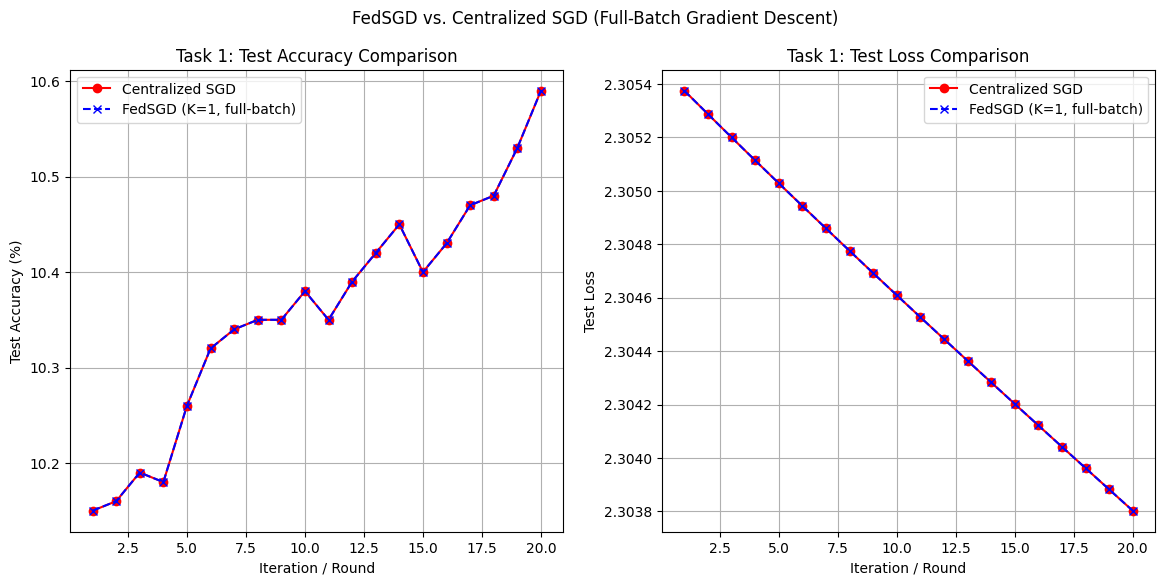


Analysis:
The plots for Test Accuracy and Test Loss for both methods should
overlap perfectly. This, combined with the near-zero L2 norm,
demonstrates the theoretical equivalence as required by Task 1.


In [11]:
###
# STEP 6: PLOTTING AND ANALYSIS
###

plt.figure(figsize=(14, 6))
iters = range(1, ITERATIONS + 1)

# --- Plot 1: Accuracy ---
plt.subplot(1, 2, 1)
plt.plot(iters, centralized_history['accuracy'], 'r-o', label='Centralized SGD')
plt.plot(iters, fedsgd_history['accuracy'], 'b--x', label='FedSGD (K=1, full-batch)')
plt.title('Task 1: Test Accuracy Comparison')
plt.xlabel('Iteration / Round')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.grid(True)

# --- Plot 2: Loss ---
plt.subplot(1, 2, 2)
plt.plot(iters, centralized_history['loss'], 'r-o', label='Centralized SGD')
plt.plot(iters, fedsgd_history['loss'], 'b--x', label='FedSGD (K=1, full-batch)')
plt.title('Task 1: Test Loss Comparison')
plt.xlabel('Iteration / Round')
plt.ylabel('Test Loss')
plt.legend()
plt.grid(True)

plt.suptitle('FedSGD vs. Centralized SGD (Full-Batch Gradient Descent)')
plt.show()

print("\nAnalysis:")
print("The plots for Test Accuracy and Test Loss for both methods should")
print("overlap perfectly. This, combined with the near-zero L2 norm,")
print("demonstrates the theoretical equivalence as required by Task 1.")